# Library / Packages

In [1]:
# basic
import pandas as pd
import numpy as np

# data preparation
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 

# data modeling
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# data scoring


# data tuning

# visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Format

In [2]:
def lab_round(x, pos): 
    if abs(x) >= 1e9: 
        return f'{x/1e9} B'
    
    elif abs(x) >= 1e6:
        return f'{x/1e6} M'
    
    elif abs(x) >= 1e3:
        return f'{x/1e3} K'
    
    else:
        return f'{x}'
    
def val_round(x):
    if abs(x) >= 1e9:
        return f'{x/1e9:.2f} B'
    
    elif abs(x) >= 1e6:
        return f'{x/1e6:.2f} M'
    
    elif abs(x) >= 1e3:
        return f'{x/1e3:.2f} K'
    
    else:
        return f'{x:.2f}'

In [3]:
def filter_outliers_iqr(df, columns = None, threshold = 1.5):
    # Jika tidak ada kolom yang ditentukan, gunakan semua kolom numerik
    if columns is None:
        columns = df.select_dtypes(include = ["number"]).columns.tolist()
    
    # Salin DataFrame untuk memastikan tidak ada modifikasi langsung
    df_filtered = df.copy()
    
    for column in columns:
        # Hitung Q1, Q3, dan IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Hitung batas bawah dan atas
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Hapus baris dengan outlier
        df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]
    
    return df_filtered

In [4]:
# Fungsi untuk konversi tipe data
def convert_object_columns_to_numeric(df):
    for col in df.select_dtypes(include = ['object']).columns:  
        try:
            # Cek apakah semua nilai bisa dikonversi ke float
            df[col] = pd.to_numeric(df[col], errors='raise')
            
            # Jika bisa, ubah ke int jika semua nilai adalah bilangan bulat
            if all(df[col] % 1 == 0):  # Cek apakah semua nilai adalah bilangan bulat
                df[col] = df[col].astype(int)

        except ValueError:
            pass  # Jika ada nilai non-angka, biarkan tetap object
        
    return df

# Dataset

In [5]:
# Memuat data train dan test
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')

In [6]:
# show all column
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Train Dataset

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
# drop column
train_df = train_df.drop('Id', axis = 1)

# convert object if all numeric
train_df = convert_object_columns_to_numeric(train_df)

# check duplicate general data
print(f'Total General Duplicated: {train_df.duplicated().sum()} \n')
train_df.info()

Total General Duplicated: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 no

In [9]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
# null column
null_numeric = []
null_obj = []

# 
null_columns = train_df.columns[train_df.isnull().sum() > 0]

for col in null_columns:
    if train_df[col].dtype in ['int', 'float']:
        null_numeric.append(col)
        
    elif train_df[col].dtype == 'object':
        null_obj.append(col)

# 
print("Null Numeric:", null_numeric)
print("Null String:", null_obj)

Null Numeric: ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
Null String: ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


In [11]:
# 
num_cols = []
obj_cols = []

for col in train_df:
    if train_df[col].dtype in ['int', 'float']:
        num_cols.append(col)
        
    elif train_df[col].dtype == 'object':
        obj_cols.append(col)

# 
print("Numeric Cols:", num_cols)
print("String Cols:", obj_cols)

Numeric Cols: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
String Cols: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 

In [12]:
# Original columns
train_original = train_df.columns

# Numeric Pipeline
numerical_pipeline = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "mean"))
])

# String Pipeline
categorical_pipeline = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "most_frequent"))
])

# ColumnTransformer untuk menggabungkan proses imputasi
prep_stage_1 = ColumnTransformer(
    transformers = [
        ("num", numerical_pipeline, num_cols), 
        ("cat", categorical_pipeline, obj_cols), 
    ], 
    remainder = "drop", 
    verbose_feature_names_out = True)

In [13]:
# Transform data menggunakan fit_transform pada tahap 1
train_df = prep_stage_1.fit_transform(train_df)

# Columns After: ubah kembali ke DataFrame dengan kolom dari prep_stage_1
train_df = pd.DataFrame(train_df, columns = prep_stage_1.get_feature_names_out())

# Hilangkan prefix (misalnya, "num__", "cat__", "out__")
clean_columns = [col.split("__", 1)[-1] for col in train_df.columns]
train_df.columns = clean_columns

In [14]:
# Menampilkan total null pada setiap kolom
null_columns = train_df.isnull().sum()[train_df.isnull().sum() > 0]
print(f'Total null columns: {null_columns} \n')
train_df.info()

Total null columns: Series([], dtype: int64) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   object
 1   LotFrontage    1460 non-null   object
 2   LotArea        1460 non-null   object
 3   OverallQual    1460 non-null   object
 4   OverallCond    1460 non-null   object
 5   YearBuilt      1460 non-null   object
 6   YearRemodAdd   1460 non-null   object
 7   MasVnrArea     1460 non-null   object
 8   BsmtFinSF1     1460 non-null   object
 9   BsmtFinSF2     1460 non-null   object
 10  BsmtUnfSF      1460 non-null   object
 11  TotalBsmtSF    1460 non-null   object
 12  1stFlrSF       1460 non-null   object
 13  2ndFlrSF       1460 non-null   object
 14  LowQualFinSF   1460 non-null   object
 15  GrLivArea      1460 non-null   object
 16  BsmtFullBath   1460 non-null   object
 17  BsmtHalfBath   1460 non-

In [15]:
# change object after transform
train_df = convert_object_columns_to_numeric(train_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   LotFrontage    1460 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1460 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

In [16]:
# Cetak jumlah baris sebelum filter
print(f"Total Rows Before Filtering: {len(train_df)}")

# Pilih kolom numerik
num_cols = train_df.select_dtypes(include = ["number"]).columns

# Terapkan filter pada kolom numerik
train_df = filter_outliers_iqr(train_df, columns = num_cols)

# Cetak jumlah baris setelah filter
print(f"Total Rows After Filtering: {len(train_df)}")

Total Rows Before Filtering: 1460
Total Rows After Filtering: 557


In [17]:
# Daftar kolom untuk label encoding (kolom ordinal)
encoding_set = {'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 
                'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 
                'FireplaceQu', 'GarageQual', 'GarageCond'}

# Inisialisasi list untuk menyimpan kolom yang telah dikelompokkan
train_ordinal_cols = []
train_one_hot_cols = []
train_numeric_cols = []

# Mengelompokkan kolom berdasarkan tipe data
for col in train_df.columns:
    if train_df[col].dtype in ['int', 'float']:
        train_numeric_cols.append(col)

    elif train_df[col].dtype == 'object':
        if col in encoding_set:
            train_ordinal_cols.append(col)

        else:
            train_one_hot_cols.append(col)

# Menampilkan hasil
print("Ordinal Encoding Columns:", train_ordinal_cols)
print("One-Hot Encoding Columns:", train_one_hot_cols)
print("Numeric Columns:", train_numeric_cols)

Ordinal Encoding Columns: ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
One-Hot Encoding Columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Numeric Columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYr

## Test Dataset

In [18]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [19]:
# drop column
test_df = test_df.drop('Id', axis = 1)

# convert object if all numeric
test_df = convert_object_columns_to_numeric(test_df)

# check duplicate general data
print(f'Total General Duplicated: {test_df.duplicated().sum()} \n')
test_df.info()

Total General Duplicated: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 no

In [20]:
# null column
null_numeric = []
null_obj = []

# 
null_columns = test_df.columns[test_df.isnull().sum() > 0]

for col in null_columns:
    if test_df[col].dtype in ['int', 'float']:
        null_numeric.append(col)
        
    elif test_df[col].dtype == 'object':
        null_obj.append(col)

# 
print("Null Numeric:", null_numeric)
print("Null String:", null_obj)

Null Numeric: ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']
Null String: ['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


In [21]:
# 
num_cols = []
obj_cols = []

for col in test_df:
    if test_df[col].dtype in ['int', 'float']:
        num_cols.append(col)
        
    elif test_df[col].dtype == 'object':
        obj_cols.append(col)

# 
print("Numeric Cols:", num_cols)
print("String Cols:", obj_cols)

Numeric Cols: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
String Cols: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish

In [22]:
# Original columns
test_original = test_df.columns

# Numeric Pipeline
numerical_pipeline = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "mean"))
])

# String Pipeline
categorical_pipeline = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "most_frequent"))
])

# ColumnTransformer untuk menggabungkan proses imputasi
prep_stage_1 = ColumnTransformer(
    transformers = [
        ("num", numerical_pipeline, num_cols), 
        ("cat", categorical_pipeline, obj_cols), 
    ], 
    remainder = "drop", 
    verbose_feature_names_out = True)

In [23]:
# Transform data menggunakan fit_transform pada tahap 1
test_df = prep_stage_1.fit_transform(test_df)

# Columns After: ubah kembali ke DataFrame dengan kolom dari prep_stage_1
test_df = pd.DataFrame(test_df, columns = prep_stage_1.get_feature_names_out())

# Hilangkan prefix (misalnya, "num__", "cat__", "out__")
clean_columns = [col.split("__", 1)[-1] for col in test_df.columns]
test_df.columns = clean_columns

In [24]:
# Menampilkan total null pada setiap kolom
null_columns = test_df.isnull().sum()[test_df.isnull().sum() > 0]
print(f'Total null columns: {null_columns} \n')
test_df.info()

Total null columns: Series([], dtype: int64) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1459 non-null   object
 1   LotFrontage    1459 non-null   object
 2   LotArea        1459 non-null   object
 3   OverallQual    1459 non-null   object
 4   OverallCond    1459 non-null   object
 5   YearBuilt      1459 non-null   object
 6   YearRemodAdd   1459 non-null   object
 7   MasVnrArea     1459 non-null   object
 8   BsmtFinSF1     1459 non-null   object
 9   BsmtFinSF2     1459 non-null   object
 10  BsmtUnfSF      1459 non-null   object
 11  TotalBsmtSF    1459 non-null   object
 12  1stFlrSF       1459 non-null   object
 13  2ndFlrSF       1459 non-null   object
 14  LowQualFinSF   1459 non-null   object
 15  GrLivArea      1459 non-null   object
 16  BsmtFullBath   1459 non-null   object
 17  BsmtHalfBath   1459 non-

In [25]:
# change object after transform
test_df = convert_object_columns_to_numeric(test_df)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   LotFrontage    1459 non-null   float64
 2   LotArea        1459 non-null   int64  
 3   OverallQual    1459 non-null   int64  
 4   OverallCond    1459 non-null   int64  
 5   YearBuilt      1459 non-null   int64  
 6   YearRemodAdd   1459 non-null   int64  
 7   MasVnrArea     1459 non-null   float64
 8   BsmtFinSF1     1459 non-null   float64
 9   BsmtFinSF2     1459 non-null   float64
 10  BsmtUnfSF      1459 non-null   float64
 11  TotalBsmtSF    1459 non-null   float64
 12  1stFlrSF       1459 non-null   int64  
 13  2ndFlrSF       1459 non-null   int64  
 14  LowQualFinSF   1459 non-null   int64  
 15  GrLivArea      1459 non-null   int64  
 16  BsmtFullBath   1459 non-null   float64
 17  BsmtHalfBath   1459 non-null   float64
 18  FullBath

In [26]:
# Cetak jumlah baris sebelum filter
print(f"Total Rows Before Filtering: {len(test_df)}")

# Pilih kolom numerik
num_cols = test_df.select_dtypes(include = ["number"]).columns

# Terapkan filter pada kolom numerik
test_df = filter_outliers_iqr(test_df, columns = num_cols)

# Cetak jumlah baris setelah filter
print(f"Total Rows After Filtering: {len(test_df)}")

Total Rows Before Filtering: 1459
Total Rows After Filtering: 543


In [27]:
# Daftar kolom untuk label encoding (kolom ordinal)
encoding_set = {'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 
                'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 
                'FireplaceQu', 'GarageQual', 'GarageCond'}

# Inisialisasi list untuk menyimpan kolom yang telah dikelompokkan
test_ordinal_cols = []
test_one_hot_cols = []
test_numeric_cols = []

# Mengelompokkan kolom berdasarkan tipe data
for col in test_df.columns:
    if test_df[col].dtype in ['int', 'float']:
        test_numeric_cols.append(col)

    elif test_df[col].dtype == 'object':
        if col in encoding_set:
            test_ordinal_cols.append(col)

        else:
            test_one_hot_cols.append(col)

# Menampilkan hasil
print("Ordinal Encoding Columns:", test_ordinal_cols)
print("One-Hot Encoding Columns:", test_one_hot_cols)
print("Numeric Columns:", test_numeric_cols)

Ordinal Encoding Columns: ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
One-Hot Encoding Columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Numeric Columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYr

## Split Set

In [28]:
# Identifikasi kolom-kolom yang ada di train dan test
ordinal_encoding_cols = list(set(train_ordinal_cols) & set(test_ordinal_cols))
one_hot_encoding_cols = list(set(train_one_hot_cols) & set(test_one_hot_cols))
numeric_cols = list(set(train_numeric_cols) & set(test_numeric_cols))

# 
print(f'ordinal cols: {ordinal_encoding_cols}')
print(f'one-hot cols: {one_hot_encoding_cols}')
print(f'numeric cols: {numeric_cols}')

ordinal cols: ['GarageCond', 'KitchenQual', 'ExterQual', 'BsmtCond', 'ExterCond', 'BsmtQual', 'HeatingQC', 'GarageQual', 'FireplaceQu']
one-hot cols: ['Functional', 'PoolQC', 'SaleCondition', 'CentralAir', 'Street', 'BsmtFinType1', 'BsmtFinType2', 'MSZoning', 'Heating', 'Exterior1st', 'Electrical', 'Fence', 'MasVnrType', 'HouseStyle', 'SaleType', 'RoofStyle', 'Alley', 'Exterior2nd', 'GarageType', 'RoofMatl', 'PavedDrive', 'Utilities', 'Condition2', 'MiscFeature', 'BldgType', 'BsmtExposure', 'LandSlope', 'LotConfig', 'Foundation', 'Condition1', 'GarageFinish', 'LandContour', 'LotShape', 'Neighborhood']
numeric cols: ['BedroomAbvGr', 'BsmtFullBath', 'OpenPorchSF', 'GarageYrBlt', 'YearBuilt', 'BsmtUnfSF', '3SsnPorch', 'BsmtHalfBath', 'GrLivArea', 'KitchenAbvGr', 'EnclosedPorch', 'BsmtFinSF2', '2ndFlrSF', 'Fireplaces', 'PoolArea', 'TotRmsAbvGrd', 'YearRemodAdd', '1stFlrSF', 'GarageCars', 'MoSold', 'YrSold', 'BsmtFinSF1', 'ScreenPorch', 'HalfBath', 'GarageArea', 'LowQualFinSF', 'LotArea', '

In [29]:
# transform
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)
ordinal_transformer = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)

prep_stage_2 = ColumnTransformer(
    transformers = [
        ("num", numerical_transformer, numeric_cols), 
        ("cat", categorical_transformer, one_hot_encoding_cols), 
        ("ord", ordinal_transformer, ordinal_encoding_cols)
    ], remainder = "passthrough")

### Train Data

In [30]:
# Transform data
transformed_data = prep_stage_2.fit_transform(train_df)

# Membuat DataFrame dengan kolom hasil transformasi
# ====================================================
# Mendapatkan nama kolom baru untuk OneHotEncoder
categorical_feature_names = prep_stage_2.named_transformers_["cat"].get_feature_names_out(one_hot_encoding_cols)

# Gabungkan semua nama kolom
all_columns = (
    numeric_cols +
    list(categorical_feature_names) +
    ordinal_encoding_cols +
    list(train_df.columns.difference(numeric_cols + one_hot_encoding_cols + ordinal_encoding_cols))
)

# Membuat DataFrame dengan nama kolom yang sesuai
train_df = pd.DataFrame(transformed_data, columns = all_columns)

# Menampilkan total null pada setiap kolom
null_columns = train_df.isnull().sum()[train_df.isnull().sum() > 0]
print(f'Train Stage 2 Check: {null_columns}')
train_df.head(3)

Train Stage 2 Check: Series([], dtype: int64)


,BedroomAbvGr,BsmtFullBath,OpenPorchSF,GarageYrBlt,YearBuilt,BsmtUnfSF,3SsnPorch,BsmtHalfBath,GrLivArea,KitchenAbvGr,EnclosedPorch,BsmtFinSF2,2ndFlrSF,Fireplaces,PoolArea,TotRmsAbvGrd,YearRemodAdd,1stFlrSF,GarageCars,MoSold,YrSold,BsmtFinSF1,ScreenPorch,HalfBath,GarageArea,LowQualFinSF,LotArea,MSSubClass,WoodDeckSF,OverallCond,MiscVal,FullBath,TotalBsmtSF,OverallQual,LotFrontage,MasVnrArea,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Typ,PoolQC_Gd,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,CentralAir_N,CentralAir_Y,Street_Grvl,Street_Pave,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Unf,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Heating_GasA,Heating_GasW,Heating_Grav,Exterior1st_AsbShng,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Electrical_FuseA,Electrical_FuseF,Electrical_SBrkr,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,Alley_Grvl,Alley_Pave,Exterior2nd_AsbShng,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_Detchd,RoofMatl_CompShg,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Utilities_AllPub,Condition2_Norm,MiscFeature_Shed,BldgType_1Fam,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,LandSlope_Gtl,LandSlope_Mod,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Wood,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,Neighborhood_Blmngtn,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,GarageCond,KitchenQual,ExterQual,BsmtCond,ExterCond,BsmtQual,HeatingQC,GarageQual,FireplaceQu,SalePrice
0,0.294737,1.157781,0.439408,0.774046,0.784193,-1.103434,0.0,0.0,0.725374,0.0,0.0,0.0,1.314747,-0.944263,0.0,1.291657,0.704506,-0.901932,0.273711,-1.633929,0.161764,0.639427,0.0,1.266019,0.383002,0.0,-0.284244,0.356986,-0.923836,-0.523677,0.0,0.787362,-0.697482,0.614520,-0.280030,1.177146,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,2.0,2.0,2.0,2.0,0.0,

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557 entries, 0 to 556
Columns: 198 entries, BedroomAbvGr to SalePrice
dtypes: float64(198)
memory usage: 861.7 KB


### Test Data

In [32]:
# Transform data
transformed_data = prep_stage_2.fit_transform(test_df)

# Membuat DataFrame dengan kolom hasil transformasi
# ====================================================
# Mendapatkan nama kolom baru untuk OneHotEncoder
categorical_feature_names = prep_stage_2.named_transformers_["cat"].get_feature_names_out(one_hot_encoding_cols)

# Gabungkan semua nama kolom
all_columns = (
    numeric_cols +
    list(categorical_feature_names) +
    ordinal_encoding_cols +
    list(test_df.columns.difference(numeric_cols + one_hot_encoding_cols + ordinal_encoding_cols))
)

# Membuat DataFrame dengan nama kolom yang sesuai
test_df = pd.DataFrame(transformed_data, columns = all_columns)

# Menampilkan total null pada setiap kolom
null_columns = test_df.isnull().sum()[test_df.isnull().sum() > 0]
print(f'Test Stage 2 Check: {null_columns}')
test_df.tail(3)

Test Stage 2 Check: Series([], dtype: int64)


,BedroomAbvGr,BsmtFullBath,OpenPorchSF,GarageYrBlt,YearBuilt,BsmtUnfSF,3SsnPorch,BsmtHalfBath,GrLivArea,KitchenAbvGr,EnclosedPorch,BsmtFinSF2,2ndFlrSF,Fireplaces,PoolArea,TotRmsAbvGrd,YearRemodAdd,1stFlrSF,GarageCars,MoSold,YrSold,BsmtFinSF1,ScreenPorch,HalfBath,GarageArea,LowQualFinSF,LotArea,MSSubClass,WoodDeckSF,OverallCond,MiscVal,FullBath,TotalBsmtSF,OverallQual,LotFrontage,MasVnrArea,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,PoolQC_Ex,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,CentralAir_N,CentralAir_Y,Street_Grvl,Street_Pave,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Unf,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Heating_GasA,Heating_GasW,Exterior1st_AsbShng,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Electrical_FuseA,Electrical_FuseF,Electrical_SBrkr,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,Alley_Grvl,Alley_Pave,Exterior2nd_AsbShng,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,RoofMatl_CompShg,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Utilities_AllPub,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosN,MiscFeature_Shed,BldgType_1Fam,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,LandSlope_Gtl,LandSlope_Mod,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,GarageCond,KitchenQual,ExterQual,BsmtCond,ExterCond,BsmtQual,HeatingQC,GarageQual,FireplaceQu
540,0.303314,1.202475,-0.133651,0.822156,0.812962,-0.632378,0.0,0.0,1.354196,0.0,0.0,0.0,-0.812116,2.652834,0.0,1.405159,0.811425,2.746259,1.674376,1.919910,-1.373927,2.247367,0.0,-0.841214,1.286168,0.0,1.607988,-0.95832,0.744445,-0.531269,0.0,0.709856,2.019005,1.276933,2.068077,1.206406,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [33]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Columns: 201 entries, BedroomAbvGr to FireplaceQu
dtypes: float64(201)
memory usage: 852.8 KB


### Target Data

In [34]:
# Memisahkan kolom target dari data
target_col = 'SalePrice'

# Memastikan kolom target ada di dalam DataFrame sebelum mencoba memisahkannya
if target_col in train_df.columns:
    X_train = train_df.drop(columns = [target_col])
    y_train = train_df[target_col]

else:
    X_train = train_df  
    y_train = None  

if target_col in test_df.columns:
    X_test = test_df.drop(columns = [target_col])
    
else:
    X_test = test_df  

# Modeling

## Set Parameter

In [35]:
# Membuat pipeline yang menggabungkan preprocessing dengan model
model_pipeline = Pipeline(steps = [
    ('regressor', LinearRegression())
])

In [36]:
# Definisikan parameter grid untuk GridSearchCV dengan beberapa model
param_grid = [
    {'regressor': [LinearRegression()]},
    {
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 100.0, 1000.0, 10000.0], 
        'regressor__max_iter': [50000, 100000, 200000], 
        'regressor__tol': [1e-3, 1e-4, 1e-6] 
    },
    {
        'regressor': [Lasso()],
        'regressor__alpha': [0.1, 1.0, 100.0, 1000.0, 10000.0],
        'regressor__max_iter': [50000, 100000, 200000],
        'regressor__tol': [1e-3, 1e-4, 1e-6]
    },
]

## Checking Null and Infinite

In [37]:
# Cek NaN dan Inf di X_train
print(f"Jumlah NaN di X_train: {pd.isna(X_train).sum().sum()}")
X_train_numeric = X_train.select_dtypes(include = ['number'])
print(f"Jumlah Inf di X_train: {(np.isinf(X_train_numeric).sum().sum())} \n")

# Cek NaN dan Inf di y_train
print(f"Jumlah NaN di y_train: {pd.isna(y_train).sum()}")
y_train_numeric = y_train
print(f"Jumlah Inf di y_train: {(np.isinf(y_train_numeric).sum().sum())}")

Jumlah NaN di X_train: 0
Jumlah Inf di X_train: 0 

Jumlah NaN di y_train: 0
Jumlah Inf di y_train: 0


In [38]:
# Cek NaN dan Inf di X_test
print(f"Jumlah NaN di X_test: {pd.isna(X_test).sum().sum()}")
X_test_numeric = X_test.select_dtypes(include = ['number'])
print(f"Jumlah Inf di X_test: {(np.isinf(X_test_numeric).sum().sum())} \n")

Jumlah NaN di X_test: 0
Jumlah Inf di X_test: 0 



## Comparing after transform stage 2

In [39]:
# 
not_in_x_test = set(X_train.columns) - set(X_test.columns)
not_in_x_train = set(X_test.columns) - set(X_train.columns)

print(f"Kolom yang ada di X_train tapi tidak ada di X_test: {not_in_x_test}")
print(f"Kolom yang ada di X_test tapi tidak ada di X_train: {not_in_x_train}")

Kolom yang ada di X_train tapi tidak ada di X_test: {'Heating_Grav', 'Exterior2nd_Stone', 'Foundation_Wood', 'Neighborhood_NPkVill', 'Functional_Maj1', 'PoolQC_Gd', 'Functional_Maj2'}
Kolom yang ada di X_test tapi tidak ada di X_train: {'GarageType_2Types', 'Condition2_PosN', 'MSZoning_C (all)', 'Condition2_Feedr', 'PoolQC_Ex', 'Condition1_PosA', 'Condition2_Artery', 'GarageType_CarPort', 'Neighborhood_Blueste', 'Condition1_RRNn', 'Functional_Mod'}


In [40]:
# 
X_train = X_train.drop(columns = not_in_x_test)
X_test = X_test.drop(columns = not_in_x_train)

# 
not_in_x_test = set(X_train.columns) - set(X_test.columns)
not_in_x_train = set(X_test.columns) - set(X_train.columns)

print(f"Kolom yang ada di X_train tapi tidak ada di X_test: {not_in_x_test}")
print(f"Kolom yang ada di X_test tapi tidak ada di X_train: {not_in_x_train}")

Kolom yang ada di X_train tapi tidak ada di X_test: set()
Kolom yang ada di X_test tapi tidak ada di X_train: set()


## Implement module

In [41]:
# Melakukan Grid Search
grid_search = GridSearchCV(model_pipeline, param_grid, cv = 5, scoring = 'neg_mean_squared_error', error_score = np.nan, verbose = 1)

# Memeriksa apakah y_train tidak None dan ukuran X_train sesuai
if y_train is not None and X_train.shape[0] == y_train.shape[0]:
    grid_search.fit(X_train, y_train)
    
else:
    raise ValueError("Ukuran X_train dan y_train tidak cocok atau y_train tidak tersedia.")

Fitting 5 folds for each of 91 candidates, totalling 455 fits


d:\GIT Data\House price\my_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.718e+08, tolerance: 1.339e+08
  model = cd_fast.enet_coordinate_descent(
d:\GIT Data\House price\my_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.955e+08, tolerance: 1.377e+08
  model = cd_fast.enet_coordinate_descent(
d:\GIT Data\House price\my_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4

In [42]:
# Model terbaik dari Grid Search
best_model = grid_search.best_estimator_

# Prediksi harga rumah pada data testing menggunakan model terbaik
y_pred = best_model.predict(X_test)

# Menampilkan prediksi
print(f"Predicted prices: \n{y_pred} \n")
print(f'Best parameters: {grid_search.best_params_}')

Predicted prices: 
[192985.61676846 201095.99415631 181018.08322317 165676.15266523
 207848.46495958 328815.01273957 247693.37003537 304436.95052925
 212621.15503106 171368.45626915 181296.86405452 202085.92595326
 239373.27073303 201242.30978116 193272.16008502 279271.45188427
 235278.58677113 200771.62041759 273790.3736285  169842.67739429
 151780.4096119  217908.32364525 145364.83798513 121237.77857709
 149882.88512747 166269.28624195 156130.01341756 141391.59207655
 176920.86769695 122668.0773293  174614.83364166  93698.9249966
 237904.58009393 147665.77097718 252528.81427084 190231.63302049
 139888.74536198 195966.05346155 124143.83504755 286601.25204847
 227846.63593905 144720.78510423 126400.03283687  88600.66486979
 190494.88731922 175495.86258375  46807.53860557 249184.16291068
 216177.1142216  184715.81331031 152658.28634133 129308.50604087
 194927.63146448 171746.66981352 120266.43357171 153510.78715565
 138533.24056859 197511.98594839 281455.15188351 200532.31834148
 233008

# Visualization

AttributeError: module 'matplotlib.pyplot' has no attribute 'yaxis'

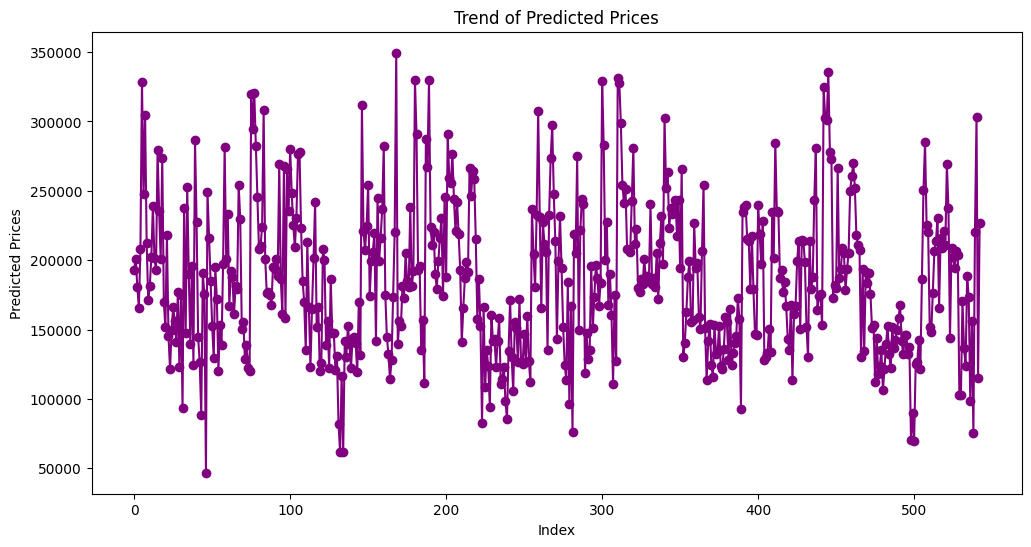

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(range(len(y_pred)), y_pred, marker='o', linestyle='-', color='purple')

plt.xlabel("Index")
plt.ylabel("Predicted Prices")
plt.title("Trend of Predicted Prices")

# plt.yaxis.set_major_formatter(ticker.FuncFormatter(lab_round))

plt.grid(True)
plt.show()